In [26]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as mp
%matplotlib inline

col_acq = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
        'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
        'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
        'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd'];

col_per = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
          'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
          'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
          'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
          'FPWA','ServicingIndicator'];

df_acq = pd.read_csv('Acquisition_2007Q3.txt', sep='|', names=col_acq, index_col=False)
df_per = pd.read_csv('Performance_2007Q3.txt', sep='|', names=col_per, usecols=[0, 15], index_col=False)

In [27]:
df_per.drop_duplicates(subset='LoanID', keep='last', inplace=True)
df = pd.merge(df_acq, df_per, on='LoanID', how='inner')

df.rename(index=str, columns={"ForeclosureDate": 'Default'}, inplace=True)

In [28]:
df['Default'].fillna(0, inplace=True)
df.loc[df['Default'] != 0, 'Default'] = 1

df['Default'] = df['Default'].astype(int)

In [29]:
df.apply(lambda x: x.isnull().sum(), axis=0)

LoanID                 0
Channel                0
SellerName             0
OrInterestRate         0
OrUnpaidPrinc          0
OrLoanTerm             0
OrDate                 0
FirstPayment           0
OrLTV                  0
OrCLTV                 0
NumBorrow             10
DTIRat              9143
CreditScore          639
FTHomeBuyer            0
LoanPurpose            0
PropertyType           0
NumUnits               0
OccStatus              0
PropertyState          0
Zip                    0
MortInsPerc       259127
ProductType            0
CoCreditScore     183703
MortInsType       259127
RelMortInd             0
Default                0
dtype: int64

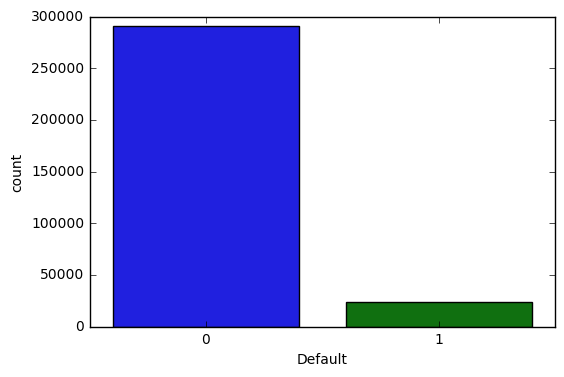

In [30]:
sns.countplot(df['Default'])

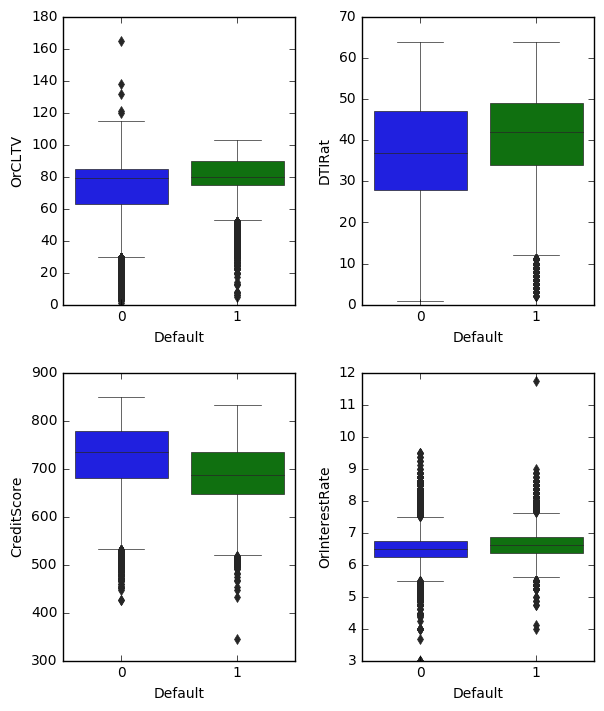

In [31]:
columns = ['OrCLTV','DTIRat','CreditScore','OrInterestRate']

fig, axes = mp.subplots(nrows=2, ncols=2, figsize=(6,7))
mp.tight_layout(w_pad=2.0, h_pad=3.0)

for i, column in zip(range(1,5), columns):
    mp.subplot(2,2,i)
    sns.boxplot(x="Default", y=column, data=df, linewidth=0.5)
    mp.xlabel('Default')

In [32]:
df['OrDateMonth'] = df['OrDate'].apply(lambda x: x.split('/')[0].strip()).astype(int)
df['OrDateYear'] = df['OrDate'].apply(lambda x: x.split('/')[1].strip()).astype(int)

df['FirstMonth'] = df['FirstPayment'].apply(lambda x: x.split('/')[0].strip()).astype(int)
df['FirstYear'] = df['FirstPayment'].apply(lambda x: x.split('/')[1].strip()).astype(int)

df.drop(['OrDate','FirstPayment'], axis=1, inplace=True)

In [33]:
df.drop(['MortInsPerc','MortInsType','CoCreditScore','ProductType','LoanID'], axis=1, inplace=True)

In [34]:
def getdummies(df):
    columns = df.columns[df.isnull().any()]
    nan_cols = df[columns]

    df.drop(nan_cols.columns, axis=1, inplace=True)

    cat = df.select_dtypes(include=['object'])
    num = df.drop(cat.columns, axis=1)

    data = pd.DataFrame()
    for i in cat.columns:
        tmp = pd.get_dummies(cat[i], drop_first=True,prefix=i)
        data = pd.concat([data, tmp], axis=1)

    df = pd.concat([num,data,nan_cols], axis=1).reset_index(drop=True)
    return df
df = getdummies(df)

In [35]:
def fillnan(df):
    columns = df.columns[df.isnull().any()]
    for name in columns:
        y = df.loc[df[name].notnull(), name].values
        X = df.loc[df[name].notnull()].drop(columns, axis=1).values
        X_test = df.loc[df[name].isnull()].drop(columns, axis=1).values
        if df[name].dtypes == 'object':
            model = RandomForestClassifier(n_estimators=10, max_depth=3)
            model.fit(X, y)
            df.loc[df[name].isnull(), name] = model.predict(X_test)
        else:
            model = RandomForestRegressor(n_estimators=10, max_depth=3)
            model.fit(X, y)
            df.loc[df[name].isnull(), name] = model.predict(X_test)
    return df
df = fillnan(df)

In [62]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN()

y = df['Default'].values
X = df.drop(['Default'], axis=1).values

X_resampled, y_resampled = sm.fit_sample(X, y)

In [59]:
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

model = RandomForestClassifier(n_estimators=200)
model = model.fit(X_train, y_train)
predict = model.predict(X_test)

In [60]:
print(classification_report(y_test, predict))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96     72698
          1       0.53      0.02      0.05      5983

avg / total       0.90      0.92      0.89     78681



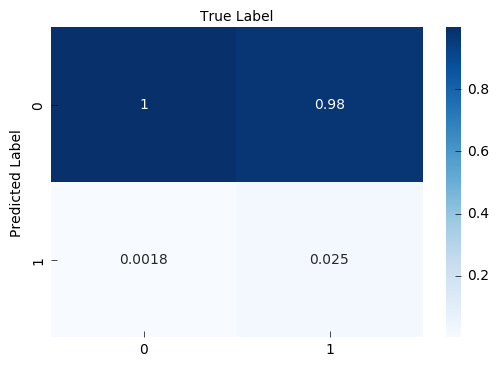

In [61]:
cm = confusion_matrix(y_test, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

fig, ax = mp.subplots()
sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = roc_auc_score(y_test, predict)

mp.plot(fpr, tpr, lw=1, label='AUC = %0.2f'%(roc_auc))
mp.plot([0, 1], [0, 1], '--k', lw=1)
mp.xlabel('False Positive Rate')
mp.ylabel('True Positive Rate')
mp.title('Random Forest ROC')
mp.legend(loc="lower right", frameon = True).get_frame().set_edgecolor('black')

In [20]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import roc_curve
import seaborn as sns
import pandas as pd
import numpy as np
from ggplot import *
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("max_colwidth",1000000)
pd.set_option('max_columns', 50)

In [36]:
Train, Test = train_test_split(df, test_size = 0.2)

X_train = Train.drop(['Default'], axis=1)
Y_train = Train["Default"]
del Train

X_test = Test.drop(['Default'], axis=1)
Y_test = Test['Default']
del Test

In [37]:
dtrain = xgb.DMatrix(X_train, label=Y_train)

dvalid = xgb.DMatrix(X_test, label=Y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [69]:
xgb_pars = {'min_child_weight': 5, 'eta': 0.5, 'colsample_bytree': 0.9, 
            'max_depth': 15,
'subsample': 0.9, 'lambda': 0.1, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'objective': 'reg:linear','seed':1234}

#xgb_pars = {'min_child_weight': 1, 'eta': 1, 'colsample_bytree': 0.9, 
#            'max_depth': 10,
#'subsample': 0.9, 'lambda': 30, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#'eval_metric': 'rmse', 'objective': 'reg:linear'}

#xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 0.9, 
#            'max_depth': 20,
#'subsample': 0.9, 'lambda': 10, 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
#'eval_metric': 'rmse', 'objective': 'reg:linear','seed' : 1234}

def evalauc(preds, dtrain):
    labels = dtrain.get_label()
    precision, recall, thresholds = precision_recall_curve(labels, preds)
    area = auc(recall, precision)
    return 'roc', -area


model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=5,
      maximize=False, verbose_eval=1,feval=evalauc)
print('Modeling AUPRC %.5f' % model.best_score)

[0]	train-rmse:0.318771	valid-rmse:0.333066	train-roc:-0.463618	valid-roc:-0.204656
Multiple eval metrics have been passed: 'valid-roc' will be used for early stopping.

Will train until valid-roc hasn't improved in 5 rounds.
[1]	train-rmse:0.244708	valid-rmse:0.277016	train-roc:-0.594156	valid-roc:-0.228325
[2]	train-rmse:0.217895	valid-rmse:0.262217	train-roc:-0.652945	valid-roc:-0.234849
[3]	train-rmse:0.205043	valid-rmse:0.259774	train-roc:-0.706682	valid-roc:-0.234482
[4]	train-rmse:0.198915	valid-rmse:0.260082	train-roc:-0.735743	valid-roc:-0.233656
[5]	train-rmse:0.192808	valid-rmse:0.261211	train-roc:-0.769194	valid-roc:-0.234182
[6]	train-rmse:0.188623	valid-rmse:0.261732	train-roc:-0.79241	valid-roc:-0.236052
[7]	train-rmse:0.185775	valid-rmse:0.262536	train-roc:-0.807222	valid-roc:-0.234572
[8]	train-rmse:0.182745	valid-rmse:0.263068	train-roc:-0.820862	valid-roc:-0.236026
[9]	train-rmse:0.1814	valid-rmse:0.263451	train-roc:-0.827327	valid-roc:-0.235395
[10]	train-rmse:0.178

In [42]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, average_precision_score,f1_score,fbeta_score,precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_validate,train_test_split,StratifiedKFold

In [48]:
X=df.drop(['Default','Zip'], axis=1).as_matrix()
y=df['Default'].as_matrix()

In [66]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# del X
# del y

In [67]:
layers=(10,10,10,10,10,10,10,10)
learning_rate_init=0.001
alpha=0.0001

#clf = MLPClassifier(solver='adam',activation='tanh',hidden_layer_sizes=layers, learning_rate='adaptive',learning_rate_init=lr_init,alpha=alpha,random_state=2)
clf = MLPClassifier(solver='adam',activation='tanh',
                    hidden_layer_sizes=layers, learning_rate='adaptive',
                    learning_rate_init=learning_rate_init,alpha=alpha,random_state=2345,
                    max_iter=200,verbose=10)

In [68]:
scorings ='average_precision'
#scorings ='accuracy'
#scorings='roc_auc'
fold=5
cv=StratifiedKFold(n_splits=fold,random_state=1234)

scores=cross_validate(clf,X_train,y_train,cv=cv,scoring=scorings,return_train_score=True)
print(scores)

Iteration 1, loss = 0.68455756
Iteration 2, loss = 0.68438477
Iteration 3, loss = 0.68438928
Iteration 4, loss = 0.68433817
Iteration 5, loss = 0.68432682
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.68456287
Iteration 2, loss = 0.68440033
Iteration 3, loss = 0.68435760
Iteration 4, loss = 0.68432736
Iteration 5, loss = 0.68433139
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.68457030
Iteration 2, loss = 0.68442348
Iteration 3, loss = 0.68436399
Iteration 4, loss = 0.68437711
Iteration 5, loss = 0.68434906
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.68452605
Iteration 2, loss = 0.68437274
Iteration 3, loss = 0.68442367
Iteration 4, loss = 0.68433358
Iteration 5, loss = 0.68432282
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, los